In [ ]:
%pip install pandas
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
%pip install opencv-python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
from PIL import Image
import json
import os
import cv2
import random
from torchvision.transforms.functional import pad

In [46]:
# Preparing the data (Load and manage the images and labels)

# Dictionary to map card labels to integers.
card_to_int = {
    'Ah': 0, '2h': 1, '3h': 2, '4h': 3, '5h': 4, '6h': 5, '7h': 6, '8h': 7, '9h': 8, 'Th': 9, 'Jh': 10, 'Qh': 11, 'Kh': 12,
    'Ac': 13, '2c': 14, '3c': 15, '4c': 16, '5c': 17, '6c': 18, '7c': 19, '8c': 20, '9c': 21, 'Tc': 22, 'Jc': 23, 'Qc': 24, 'Kc': 25,
    'Ad': 26, '2d': 27, '3d': 28, '4d': 29, '5d': 30, '6d': 31, '7d': 32, '8d': 33, '9d': 34, 'Td': 35, 'Jd': 36, 'Qd': 37, 'Kd': 38,
    'As': 39, '2s': 40, '3s': 41, '4s': 42, '5s': 43, '6s': 44, '7s': 45, '8s': 46, '9s': 47, 'Ts': 48, 'Js': 49, 'Qs': 50, 'Ks': 51
}

# Number of classes in the card dataset (52 cards).
num_classes = 52
# (channels, [dimensions of image in pixels]). RGB = 3.
input_shape = (3, 27, 38)

# Create subclass of the pytorch base custom dataset.
class ImageDataset(torch.utils.data.Dataset):

    # Initializes the parameters and loads in the native data.
    def __init__(self, root_dir, transform=None, is_table=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_table = is_table
        
        # If the dataset is the table screenshots:
        if self.is_table:
            # Opens the .json and loads the table labels, saves info required to load images later, and stores this to 'self.table_info'.
            with open(os.path.join(root_dir, 'Tables.json'), 'r') as f:
                self.table_info = json.load(f)
        # Otherwise the dataset is the card images. Lists all the files in 'Card Images' and stores them to 'self.card_info'.
        else:
            self.card_info = os.listdir(os.path.join(root_dir, 'Card Images'))

    # Gets total number of samples, used to determine the number of iterations required to go through entire dataset.
    def __len__(self):
        if self.is_table:
            return len(self.table_info)
        else:
            return len(self.card_info)

    # Load and return a sample from the dataset given an index. When using data loaders, this is called to fetch a specific sample from the dataset.
    def __getitem__(self, idx):

        if self.is_table:
            # Retrieves the tables image path and associated label for the table image.
            img_path = os.path.join(self.root_dir, 'Table Images', self.table_info[idx]['table_image'])
            label = self.table_info[idx]['table_label']
        else:
            # Retrieves the card image name and path and then extracts the truth label as the images name before '.png'.
            img_name = self.card_info[idx]
            img_path = os.path.join(root_dir, 'Card Images', img_name)
            card_label = img_name[:-4]
            label = card_to_int[card_label]
        
        # Opens the image via the card and table image paths.
        img = Image.open(img_path)
        # Converts images to RGB that were currently RGB with Alpha (RGBA).
        img = img.convert("RGB")

        # Applies the transformations to the images when they are accessed through the dataset instances. 
        if self.transform:
            img = self.transform(img)

        return img, label
    
def custom_resize(img, size):
    img_size = np.array(img.size)
    max_dim = np.argmax(img_size)
    scale_factor = size[max_dim] / img_size[max_dim]
    new_size = (int(img_size[0] * scale_factor), int(img_size[1] * scale_factor))
    return img.resize(new_size, Image.BICUBIC)
# Transforms the images shape to account for different sized cards 
cards_transform = transforms.Compose([
    transforms.Lambda(lambda img: custom_resize(img, (27, 38))),
    transforms.RandomAffine(degrees=0, scale=(0.6, 2)),
    transforms.Pad((0, 0, 38, 27), fill=0, padding_mode='constant'),
    transforms.CenterCrop((27, 38)),
    transforms.ToTensor()
])

table_transform = transforms.Compose([transforms.Resize(500, Image.BICUBIC),transforms.ToTensor()])

# ImageDataset instances.
root_dir = "C:/Users/Admin/Desktop/Primary Skills/Programming & ML/Machine Learning/Card Detection"
cards_dataset = ImageDataset(root_dir=root_dir, transform=cards_transform)
table_dataset = ImageDataset(root_dir=root_dir, transform=table_transform, is_table=True)

# Use the cards_dataset as the training set and table_dataset as the validation set.
train_dataset = cards_dataset
test_dataset = table_dataset

# Objects to provide access to the tensor data during training and testing.
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print("Data preparation completed.")
print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Number of samples in testing dataset: {len(test_dataset)}")

Data preparation completed.
Number of samples in training dataset: 52
Number of samples in testing dataset: 24


In [47]:
# Building the model (Creating custom CNN 'CardCNN' using nn.Module class)
class CardCNN(nn.Module):
    # Initialization function
    def __init__(self):
        # Constructor which initializes the layers and defines parameters.
        super(CardCNN, self).__init__()
        # convolutional layer for extracting local features/patterns. (input channels, output channels, kernel size, stride).
        self.conv1 = nn.Conv2d(3, 4, 3, 1)
        # max pooling layer for downsampling to retain important features & reduce spatial dimensions. (kernel size, stride).
        self.pool = nn.MaxPool2d(2, 2)
        # convolutional layer for extracting local features/patterns. (input channels, output channels, kernel size, stride).
        self.conv2 = nn.Conv2d(4, 8, 3, 1)
        # dropout layer for regularization. Prevents overfitting. (Probability of element dropped during dropout).
        self.dropout = nn.Dropout(0.2)
        # Allows model to accept variable sized inputs from the sliding window
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 8))
        # fully connected layer which flattens for classification. (input size, output size).
        self.fc1 = nn.Linear(8 * 5 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    # Function to define how the input flows through the layers.
    def forward(self, x):
        # Applies convolutional layer, activation function (ReLU) for non-linearity, and pooling layer to the input.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adaptive_pool(x)
        # Reshapes the output tensor to match the input size of the fully connected layer.
        x = x.view(-1, 8 * 5 * 8)
        # Applies dropout layer to prevent overfitting by randomly zeroing some elements.
        x = self.dropout(x)
        # # Applies ReLU activation function to the output of the first fully connected layer.
        x = F.relu(self.fc1(x))
        # Applies dropout layer to the output of the first fully connected layer.
        x = self.dropout(x)
        # Flattens and passes the input through the fully connected layer, performs linear transformation for classification.
        x = self.fc2(x)
        # Logarithmic softmax function applied to produce the output probabilities.
        return F.log_softmax(x, dim=1)

model = CardCNN()
print(model)

CardCNN(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(5, 8))
  (fc1): Linear(in_features=320, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=52, bias=True)
)


Epoch 10, Loss: 3.9295042478121243, Accuracy: 0.00%
Epoch 20, Loss: 3.4454732491419864, Accuracy: 7.69%
Epoch 30, Loss: 2.949946788641123, Accuracy: 17.31%
Epoch 40, Loss: 2.7177161253415623, Accuracy: 23.08%
Epoch 50, Loss: 2.544399389853844, Accuracy: 23.08%
Epoch 60, Loss: 2.3297665302570048, Accuracy: 26.92%
Epoch 70, Loss: 2.180571803679833, Accuracy: 19.23%
Epoch 80, Loss: 2.185975331526536, Accuracy: 30.77%
Epoch 90, Loss: 2.118771974857037, Accuracy: 26.92%
Epoch 100, Loss: 2.192455080839304, Accuracy: 26.92%
Epoch 110, Loss: 2.0032924230282125, Accuracy: 36.54%
Epoch 120, Loss: 1.8706209017680242, Accuracy: 28.85%
Epoch 130, Loss: 1.806884453846858, Accuracy: 26.92%
Epoch 140, Loss: 1.8529558181762695, Accuracy: 38.46%
Epoch 150, Loss: 1.8660537096170278, Accuracy: 42.31%
Epoch 160, Loss: 1.8142434725394616, Accuracy: 32.69%
Epoch 170, Loss: 1.791370309316195, Accuracy: 34.62%
Epoch 180, Loss: 1.7078356513610253, Accuracy: 44.23%
Epoch 190, Loss: 1.5028529533973107, Accuracy: 

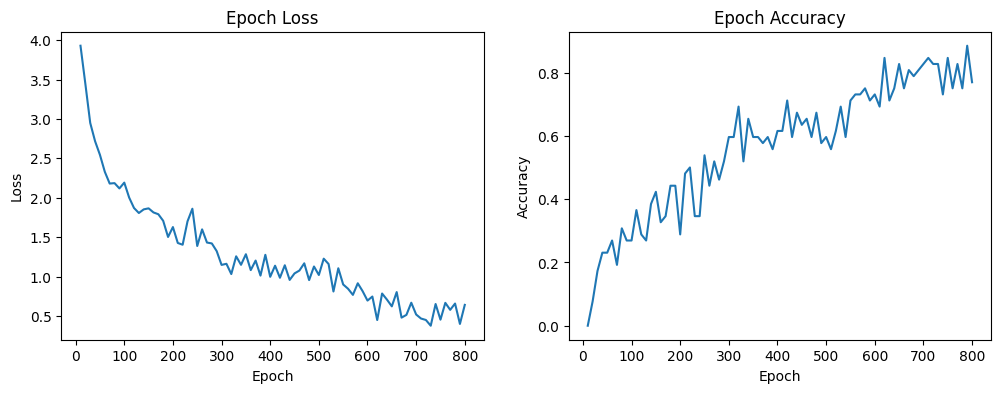

In [48]:
# Training the model on the individual cards

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer using an algo during training with the set learning rate.
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
# Loss function (combines softmax activation and negative log-likelihood loss).
criterion = nn.CrossEntropyLoss()

num_epochs = 800
print_frequency = 10
# List to store the average loss and accuracy for each epoch
losses = []  
accuracies = []

# Loop through the number of epochs.
for epoch in range(num_epochs):
    # Initialize the running loss.
    running_loss = 0.0
    # New
    correct_predictions = 0
    #iterate over the DataLoader (train_loader) to get batches of input images and their labels.
    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Move the inputs and labels to the appropriate device (CPU or GPU).
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear the gradients of the model parameters before each forward pass.
        optimizer.zero_grad()
        # Pass the input images through the model to get the predicted outputs.
        outputs = model(inputs)
        # Calculate the loss between the predicted outputs and the ground truth labels.
        loss = criterion(outputs, labels)
        # Perform backpropagation to compute gradients of the loss with respect to the model parameters.
        loss.backward()
        # Update the model parameters using the optimizer.
        optimizer.step()
        # Accumulate the running loss for each batch.
        running_loss += loss.item()
        
        # Calculate the predicted class and the number of correct predictions
        _, predicted = torch.max(outputs, dim=1)
        correct_predictions += (predicted == labels).sum().item()

    # Print the average loss every print_frequency epochs
    if (epoch + 1) % print_frequency == 0:
        average_loss = running_loss / (i + 1)
        accuracy = correct_predictions / (len(train_loader.dataset))
        # Append the average loss and accuracy to the appropriate empty lists.
        losses.append(average_loss) 
        accuracies.append(accuracy)
        print(f"Epoch {epoch + 1}, Loss: {average_loss}, Accuracy: {accuracy * 100:.2f}%")

print("Finished training")

# Plotting the epoch loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(range(print_frequency, num_epochs + 1, print_frequency), losses)
ax1.set(xlabel='Epoch', ylabel='Loss', title='Epoch Loss')
ax2.plot(range(print_frequency, num_epochs + 1, print_frequency), accuracies)
ax2.set(xlabel='Epoch', ylabel='Accuracy', title='Epoch Accuracy')
plt.show()

In [ ]:
# Multiple window sizes
#(int(1.5 * 27), int(1.5 * 38)), (2 * 27, 2 * 38)
window_sizes = [(27, 38)]
step_size = 10
threshold = 0.4

# Function to generate sliding window coordinates
def sliding_window(image, window_size, step_size):
    for window_size in window_sizes:
        for y in range(0, image.shape[0] - window_size[1], step_size):
            for x in range(0, image.shape[1] - window_size[0], step_size):
                yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Function to predict card class probabilities for a single input image
def predict_single_image(model, image):
    with torch.no_grad():
        image_tensor = torch.unsqueeze(image, 0)
        output = model(image_tensor)
        return output
    
# Iterate over the table images
for idx, (table_image, _) in enumerate(test_dataset):
    # Convert PIL Image to a numpy array and normalize it to [0, 1]
    table_image_np = np.array(table_image).transpose(1, 2, 0) / 255.0
    predictions = []

    # Iterate over the sliding windows
    for (x, y, window) in sliding_window(table_image_np, window_sizes, step_size):
        # Convert the numpy window back to a PIL Image and apply the cards_transform
        window_pil = Image.fromarray((window * 255).astype(np.uint8))
        window_transformed = table_transform(window_pil)

        # Predict card class probabilities and store the predictions with their window coordinates
        window_probs = predict_single_image(model, window_transformed)
        predictions.append(((x, y), window_probs))

    # Get the top predictions
    top_predictions = [(coords, probs) for coords, probs in predictions if torch.max(probs).item() > threshold]

    # Sort the predictions by probability
    sorted_predictions = sorted(top_predictions, key=lambda x: torch.max(x[1]).item(), reverse=True)

    # Process the sorted predictions to extract card locations and labels
    card_locations = []
    card_labels = []

    for (x, y), probs in sorted_predictions:
        # Get the index and probability of the most probable class
        max_prob, max_index = torch.max(probs, dim=-1)

        # Append the coordinates and class index to the respective lists
        card_locations.append((x, y))
        card_labels.append(max_index.item())

    print(f"Table image {idx + 1}:")
    print("Predicted labels:", card_labels)
    print("Card locations:", card_locations)
    print()